# Calculate PCA data using the Ag3 data release

The PCA data files for gamb_colu, arab and gamb_colu_arab are stored on Google Cloud Storage. Each Zarr is about 5 MB.

A few basic plots are made to eyeball the data before it is stored.

In [2]:
# Imports
import gcsfs
import pandas as pd
import zarr
import allel
import numpy as np
import matplotlib.pyplot as plt

## Settings

In [7]:
# Specify the species groups, used in file names, site filter, region and sample selection
species_groups = ['gamb_colu_arab', 'gamb_colu','arab', 'gamb_colu_arab_pca']

# The number of principal components to process
n_principal_components = 10

# Specify the storage paths
input_alleles_cloud_zarr_path_template = 'vo_agam_production/ag3_data_paper/{}.pca_umap_input_alleles.zarr'
output_cloud_zarr_path_template = 'vo_agam_production/ag3_data_paper/{}.pca_output.zarr'

## Check the output doesn't already exist

In [8]:
# Writing the PCA data to the cloud will require the appropriate authentication and authorization.

# UNCOMMENT THIS TO AUTHENTICATE. YOU ONLY NEED TO RUN THIS ONCE.
# After running this once, your authentication token should then be cached in `~/.gcs_tokens`
# Once you have authenticated, you should comment this out again to avoid re-authenticating.
# gcs_browser = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='browser')

# Use `cache_timeout=0` to prevent object list cache, to avoid recreating map for Zarr consolidated metadata
auth_fs = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache', cache_timeout=0)

# Check that the output's Zarr metadata file is not already on the cloud.
# We don't want to accidentally overwrite or delete existing data, which might have been used in downstream analysis.
# We don't simply check for the existence of the Zarr file here (i.e. output_cloud_zarr_path),
# We might want to re-run the first parts of this notebook again,
# so the Zarr store might legitimately exist but be incomplete.
# The Zarr store is not considered complete until the Zarr metadata file (.zmetadata) is present and correct.
# The final part of this notebook includes steps to create the Zarr metadata file and then validate it.

for species_group in species_groups:
    output_cloud_zarr_path = output_cloud_zarr_path_template.format(species_group)
    output_cloud_zarr_metadata_path = f'{output_cloud_zarr_path}/.zmetadata'
    if auth_fs.exists(output_cloud_zarr_metadata_path):
        print(species_group, "already exists")

species_groups = [s for s in species_groups if not auth_fs.exists(f'{output_cloud_zarr_path_template.format(s)}/.zmetadata')]
species_groups

gamb_colu_arab already exists
gamb_colu already exists
arab already exists


['gamb_colu_arab_pca']

## Get the allele counts for each species group

In [9]:
allele_count_zarr_stores = {} # Not used, but kept for convenience
allele_count_zarr_groups = {}
for species_group in species_groups:
    allele_count_zarr_stores[species_group] = auth_fs.get_mapper(input_alleles_cloud_zarr_path_template.format(species_group))
    allele_count_zarr_groups[species_group] = zarr.Group(allele_count_zarr_stores[species_group], read_only=True)

## Run the PCA

In [10]:
# NOTE: if this halts with `ValueError: array must not contain infs or NaNs`
# that might be because we've selected a non-segregating variant, where division leads to inf.

In [11]:
%%time
pca_data = {}
for species_group in species_groups:
    print(species_group)
    computed_downsampled_allele_counts = allele_count_zarr_groups[species_group]['allele_counts_pca_ready']
    pca_data[species_group] = {}
    pca_data[species_group]['coords'], pca_data[species_group]['model'] = allel.pca(computed_downsampled_allele_counts, n_components=n_principal_components, scaler='patterson')
# Wall time: 3min 29s

gamb_colu_arab_pca
CPU times: user 8min 24s, sys: 1min 27s, total: 9min 51s
Wall time: 3min 7s


In [12]:
# Eyeball the coordinates data
for species_group in species_groups:
    print(pca_data[species_group]['coords'])

[[-56.199158     1.6216763  -32.078316   ...   6.452525    -2.198913
    8.713895  ]
 [-56.973206    -0.15994862 -35.874332   ...   7.3866973   -2.9514077
   10.137623  ]
 [-57.135487     1.7590337  -34.45756    ...   6.8608766   -3.1697853
    7.7157364 ]
 ...
 [-10.911204    -4.4598913   24.8756     ...  -5.961763   -25.105558
    0.3764566 ]
 [ -8.995246    -3.7906518   24.135117   ...  -4.693306   -16.871857
    2.2899814 ]
 [ -9.463635    -5.8490367   24.309374   ...  -9.131242   -20.813654
   -0.4082242 ]]


In [13]:
# Eyeball the explained variance ratios
for species_group in species_groups:
    print(pca_data[species_group]['model'].explained_variance_ratio_)

[0.00877913 0.00584915 0.00477044 0.00331323 0.00260219 0.00249701
 0.00186931 0.00180509 0.00157818 0.00145004]


## Avoid the component orientations flipping randomly when re-run

In [14]:
%%time
for species_group in species_groups:
    
    coords = pca_data[species_group]['coords']
    components = pca_data[species_group]['model'].components_
    allele_counts = allele_count_zarr_groups[species_group]['allele_counts_pca_ready']
    
    # To avoid the component orientations flipping randomly when re-run,
    # choose the maximum absolute value for the coords to be positive
    do_inv = []
    for n_pc in range(0, len(components)):
        mx = np.max(coords[:, n_pc])
        mn = np.min(coords[:, n_pc])
        if mx >= -mn:
            do_inv.append(1)
        else:
            do_inv.append(-1)
            
    pca_data[species_group]['polarized_coords'] = np.ndarray(shape=(len(coords), len(components)))
    for n_pc in range(0, len(components)):
        for n_s in range(0, len(coords)):
            pca_data[species_group]['polarized_coords'][n_s, n_pc] = coords[n_s, n_pc] * do_inv[n_pc]
            
    pca_data[species_group]['polarized_components'] = np.ndarray(shape=(len(components), allele_counts.shape[0]))
    for n_pc in range(0, len(pca_data[species_group]['model'].components_)):
        for n_ds in range(0, allele_counts.shape[0]):
            pca_data[species_group]['polarized_components'][n_pc, n_ds] = components[n_pc, n_ds] * do_inv[n_pc]
# Wall time: 3.2 s

CPU times: user 2.67 s, sys: 9.6 ms, total: 2.68 s
Wall time: 2.9 s


## Eyeball a couple of basic PCA plots

### Matplotlib

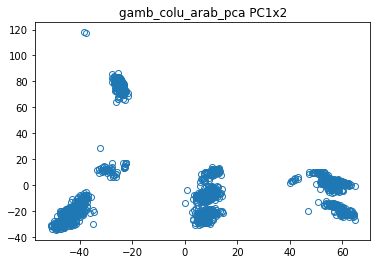

In [15]:
for species_group in species_groups:
    polarized_coords = pca_data[species_group]['polarized_coords']
    fig, ax = plt.subplots()
    ax.plot(polarized_coords[:, 0], polarized_coords[:, 1], marker='o', linestyle=' ', markerfacecolor='none')
    ax.set_title(f'{species_group} PC1x2')

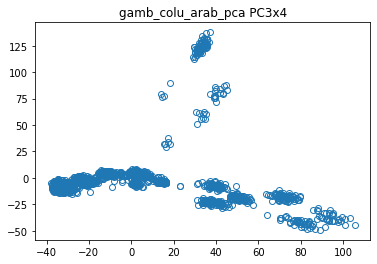

In [16]:
for species_group in species_groups:
    polarized_coords = pca_data[species_group]['polarized_coords']
    fig, ax = plt.subplots()
    ax.plot(polarized_coords[:, 2], polarized_coords[:, 3], marker='o', linestyle=' ', markerfacecolor='none')
    ax.set_title(f'{species_group} PC3x4')

## Eyeball the explained variance ratio per component

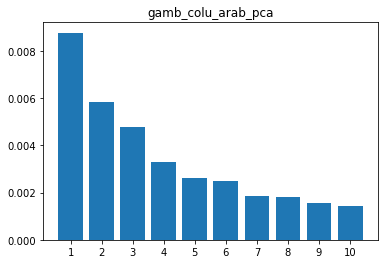

In [17]:
for species_group in species_groups:
    model = pca_data[species_group]['model']
    plt.figure(species_group)
    plt.title(species_group)
    plt.bar(range(n_principal_components), model.explained_variance_ratio_, tick_label=range(1, n_principal_components + 1))

## Store the PCA data

In [18]:
# Check the data types
for species_group in species_groups:
    polarized_coords = pca_data[species_group]['polarized_coords']
    model = pca_data[species_group]['model']
    print(species_group, type(polarized_coords), type(model.explained_variance_ratio_))

gamb_colu_arab_pca <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [19]:
pca_zarr_stores = {}
pca_zarr_groups = {}
for species_group in species_groups:

    output_cloud_zarr_path = output_cloud_zarr_path_template.format(species_group)
    print('Will attempt to store at:', output_cloud_zarr_path)

    # Sometimes errors with `overwrite=True`, sometimes errors without, when dir not exist
    # Keep the pca_zarr_store for zarr.consolidate_metadata(pca_zarr_store)
    pca_zarr_stores[species_group] = auth_fs.get_mapper(output_cloud_zarr_path)
    pca_zarr_groups[species_group] = zarr.group(pca_zarr_stores[species_group])

Will attempt to store at: vo_agam_production/ag3_data_paper/gamb_colu_arab_pca.pca_output.zarr


In [20]:
%%time
for species_group in species_groups:
    pca_zarr_group = pca_zarr_groups[species_group]
    polarized_coords = pca_data[species_group]['polarized_coords']
    model = pca_data[species_group]['model']
    sample_names = allele_count_zarr_groups[species_group]['sample_names']
    polarized_components = pca_data[species_group]['polarized_components']
    
    pca_zarr_group.create_dataset("coords", data=polarized_coords, overwrite=True) # overwrite otherwise `ValueError: path 'coords' contains an array`
    pca_zarr_group.create_dataset("explained_variance_ratio", data=model.explained_variance_ratio_, overwrite=True)
    pca_zarr_group.create_dataset("sample_names", data=sample_names, overwrite=True)
    pca_zarr_group.create_dataset("components", data=polarized_components, overwrite=True)
    # pca_zarr_group.create_dataset("downsampled_site_indices", data=downsampled_site_indices, overwrite=True)
# Wall time: 10.8 s

CPU times: user 357 ms, sys: 22 ms, total: 379 ms
Wall time: 5.29 s


## Check the stored PCA data

In [21]:
%%time
# Check all chunks are initialized
for species_group in species_groups:
    pca_zarr_group = pca_zarr_groups[species_group]
    
    assert pca_zarr_group['coords'].nchunks_initialized == pca_zarr_group['coords'].nchunks
    assert pca_zarr_group['explained_variance_ratio'].nchunks_initialized == pca_zarr_group['explained_variance_ratio'].nchunks
    assert pca_zarr_group['sample_names'].nchunks_initialized == pca_zarr_group['sample_names'].nchunks
    assert pca_zarr_group['components'].nchunks_initialized == pca_zarr_group['components'].nchunks
    #assert pca_zarr_group['downsampled_site_indices'].nchunks_initialized == pca_zarr_group['downsampled_site_indices'].nchunks
# Wall time: 1.83 s

CPU times: user 48.9 ms, sys: 1.35 ms, total: 50.3 ms
Wall time: 659 ms


In [22]:
# Check that the pca_zarr_store contains the expected arrays
for species_group in species_groups:
    pca_zarr_store = pca_zarr_stores[species_group]
    
    assert 'coords/.zarray' in pca_zarr_store
    assert 'explained_variance_ratio/.zarray' in pca_zarr_store
    assert 'sample_names/.zarray' in pca_zarr_store
    assert 'components/.zarray' in pca_zarr_store
    #assert 'downsampled_site_indices/.zarray' in pca_zarr_store

## Consolidate the Zarr metadata

In [23]:
# Consolidate the metadata
# https://zarr.readthedocs.io/en/stable/api/convenience.html#zarr.convenience.consolidate_metadata
# "Consolidate all metadata for groups and arrays within the given store into a single resource and put it under the given key."
# "This produces a single object in the backend store, containing all the metadata read from all the zarr-related keys that can be found."

for species_group in species_groups:
    pca_zarr_store = pca_zarr_stores[species_group]
    zarr.consolidate_metadata(pca_zarr_store)

## Check the consolidated Zarr metadata

In [24]:
for species_group in species_groups:
    pca_zarr_store = pca_zarr_stores[species_group]

    # Re-load the consolidated metadata, for validation
    pca_zarr_consolidated_metadata = zarr.open_consolidated(pca_zarr_store)
    
    # Test that the keys of the consolidated metadata are as expected 
    # REM: 'downsampled_site_indices', 
    assert list(pca_zarr_consolidated_metadata.keys()) == ['components', 'coords', 'explained_variance_ratio', 'sample_names']